<a href="https://colab.research.google.com/github/jess-crypto/found-the-key/blob/master/Text_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalação das bibliotecas de NLP

Usaremos a base disponibilizada no Kaggle para executar as principais tarefas de Text Analytics
Iremos nos concentrar nos textos publicados na seção de Turismo

In [1]:
#!pip install spacy pyLDAvis

Baixando a estrutura de dados para a máquina realizar interpretações de textos em Português

In [2]:
!python -m spacy download pt_core_news_sm

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-02-27 17:23:38.366622: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 17:23:39.565589: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-27 17:23:39.565760: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open share

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import nltk
import re
from nltk import word_tokenize
from nltk.util import ngrams
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Conjunto de dados

In [5]:
news = pd.read_csv('https://www.dropbox.com/s/rvwjw8miow6jswy/articles.csv?dl=1')

In [6]:
news.head()

,title,text,date,category,subcategory,link
0,"Lula diz que está 'lascado', mas que ainda tem...",Com a possibilidade de uma condenação impedir ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
1,"'Decidi ser escrava das mulheres que sofrem', ...","Para Oumou Sangaré, cantora e ativista malines...",2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
2,Três reportagens da Folha ganham Prêmio Petrob...,Três reportagens da Folha foram vencedoras do ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
3,Filme 'Star Wars: Os Últimos Jedi' ganha trail...,A Disney divulgou na noite desta segunda-feira...,2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
4,CBSS inicia acordos com fintechs e quer 30% do...,"O CBSS, banco da holding Elopar dos sócios Bra...",2017-09-10,mercado,NaN,http://www1.folha.uol.com.br/mercado/2017/10/1...


Filtrando as notícias sobre Turismo

In [7]:
turismo = news[news['category'] == 'turismo']

In [8]:
turismo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1903 entries, 381 to 167031
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        1903 non-null   object
 1   text         1903 non-null   object
 2   date         1903 non-null   object
 3   category     1903 non-null   object
 4   subcategory  0 non-null      object
 5   link         1903 non-null   object
dtypes: object(6)
memory usage: 104.1+ KB


Limpeza do texto (caracteres alfanuméricos, pontuações etc)

In [52]:
def limpa_texto(texto):
  c = re.sub(r'\n',' ', texto) #remove \n e \r
  c = re.sub(r'\r', ' ', c) #limpando caracteres no final de uma linha

  c = c.replace(':', '') #remove caracteres alfanuméricos
  c = c.replace('/', '')
  c = re.sub(r'R\$', '', c)
  c = re.sub(r'\W', ' ', c)

  c = re.sub(r'\s+', ' ', c) #remove espaços adicionais
  c = re.sub(r'^\s+', '', c) #remove espaços adicionais no início de frase
  c = re.sub(r'\s+$', '', c) #remove espaços adicionais no final das frases

  return c.lower() #reduzir todo o texto para minúsculas


In [11]:
from spacy.lang.pt import Portuguese

In [12]:
STOP_WORDS = spacy.lang.pt.stop_words.STOP_WORDS

Identificando as stop words

In [13]:
STOP_WORDS

{'a',
 'acerca',
 'ademais',
 'adeus',
 'agora',
 'ainda',
 'algo',
 'algumas',
 'alguns',
 'ali',
 'além',
 'ambas',
 'ambos',
 'antes',
 'ao',
 'aos',
 'apenas',
 'apoia',
 'apoio',
 'apontar',
 'após',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aqui',
 'aquilo',
 'as',
 'assim',
 'através',
 'atrás',
 'até',
 'aí',
 'baixo',
 'bastante',
 'bem',
 'boa',
 'bom',
 'breve',
 'cada',
 'caminho',
 'catorze',
 'cedo',
 'cento',
 'certamente',
 'certeza',
 'cima',
 'cinco',
 'coisa',
 'com',
 'como',
 'comprida',
 'comprido',
 'conhecida',
 'conhecido',
 'conselho',
 'contra',
 'contudo',
 'corrente',
 'cuja',
 'cujo',
 'custa',
 'cá',
 'da',
 'daquela',
 'daquele',
 'dar',
 'das',
 'de',
 'debaixo',
 'demais',
 'dentro',
 'depois',
 'des',
 'desde',
 'dessa',
 'desse',
 'desta',
 'deste',
 'deve',
 'devem',
 'deverá',
 'dez',
 'dezanove',
 'dezasseis',
 'dezassete',
 'dezoito',
 'diante',
 'direita',
 'disso',
 'diz',
 'dizem',
 'dizer',
 'do',
 'dois',
 'dos',
 'doze',
 'duas',
 'dá

Removendo os tokens das stop words

In [14]:
def remove_stop(texto):
  doc = nlp_pt(texto)
  return " ".join(x.text for x in doc if x.text not in STOP_WORDS)

Limpa texto 2: 
transforma todos os tokens em seu lemma (palavra de dicionário)

In [15]:
def limpa_texto2(texto):
  doc = nlp_pt(texto)
  return " ".join(x.lemma_ for x in doc if x.text not in STOP_WORDS)

Análise exploratória: possíveis questões acerca do texto

1. número de palavras no título das notícias

In [16]:
turismo['title_n_words'] = turismo['title'].apply(lambda x : len(x.split()))

In [17]:
turismo.head()

,title,text,date,category,subcategory,link,title_n_words
381,Latam inaugura voo direto de 15 horas entre Ch...,Animem-se os que pretendem cruzar o Pacífico e...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11
414,Turismo de Las Vegas deve se recuperar em mese...,O massacre em Las Vegas afetará o turismo da c...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11
522,Brasileiro cria app para economizar no passeio...,"Com cerca de 50 mil visitantes por dia, Veneza...",2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11
602,AirBnB passa a fazer reserva de restaurantes,A plataforma de hospedagem Airbnb anunciou que...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,7
609,Museus lembram quatro décadas de opressão sovi...,Nos países que viveram sob a órbita da União S...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,10


In [18]:
turismo.describe()

,title_n_words
count,1903.000000
mean,10.923805
std,1.812440
min,4.000000
25%,10.000000
50%,11.000000
75%,12.000000
max,20.000000


2. número de caracteres no título das notícias

In [19]:
turismo['title_n_chars'] = turismo['title'].apply(lambda x : len(x.replace(" ", "")))

In [20]:
turismo.head()

,title,text,date,category,subcategory,link,title_n_words,title_n_chars
381,Latam inaugura voo direto de 15 horas entre Ch...,Animem-se os que pretendem cruzar o Pacífico e...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,51
414,Turismo de Las Vegas deve se recuperar em mese...,O massacre em Las Vegas afetará o turismo da c...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,54
522,Brasileiro cria app para economizar no passeio...,"Com cerca de 50 mil visitantes por dia, Veneza...",2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,58
602,AirBnB passa a fazer reserva de restaurantes,A plataforma de hospedagem Airbnb anunciou que...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,7,38
609,Museus lembram quatro décadas de opressão sovi...,Nos países que viveram sob a órbita da União S...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,10,62


In [23]:
turismo.describe()

,title_n_words,title_n_chars
count,1903.000000,1903.000000
mean,10.923805,55.666842
std,1.812440,6.309523
min,4.000000,25.000000
25%,10.000000,52.000000
50%,11.000000,57.000000
75%,12.000000,60.000000
max,20.000000,87.000000


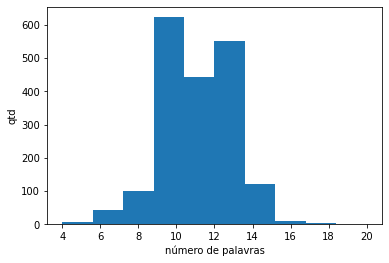

In [24]:
turismo.title_n_words.hist();
plt.xlabel('número de palavras')
plt.ylabel('qtd')
plt.grid(b=None)
plt.show()

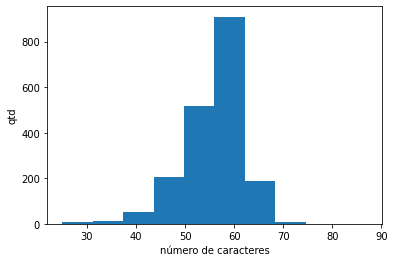

In [25]:
turismo.title_n_chars.hist();
plt.xlabel('número de caracteres')
plt.ylabel('qtd')
plt.grid(b=None)
plt.show()

Limpeza dos dados

Carregamento do corpus em língua portuguesa:

In [53]:
nlp_pt = spacy.load('pt_core_news_sm') #armazenando o corpus em nlp_pt

In [54]:
rev = turismo.iloc[0]['title'] #extraindo o título da primeira notícia

In [55]:
rev

'Latam inaugura voo direto de 15 horas entre Chile e Austrália'

In [56]:
rev = limpa_texto(rev) #aqui acontece toda a mágica do Spacy

In [57]:
rev

'latam inaugura voo direto de 15 horas entre chile e austrália'

In [58]:
rev2 = turismo.iloc[5]['title']

In [59]:
rev2

"'Viagem ao Japão é aula de cultura e tradição', diz ator Jayme Matarazzo"

In [60]:
limpa_texto(rev2)

'viagem ao japão é aula de cultura e tradição diz ator jayme matarazzo'

In [64]:
rev = nlp_pt(rev)

In [65]:
def exibe_tokens(texto):
  col_names = ['ALPHA', 'PUNCT', 'LIKE NUM', 'POS']
  formatted_text = '{:>16}' * (len(col_names)+ 1)
  print('\n', formatted_text.format('INPUT WORD', *col_names), '\n', '='*130)

  for token in texto:
    output = [token.text, token.is_alpha, token.is_punct, token.like_num, token.pos_]
    print(formatted_text.format(*output))

In [66]:
exibe_tokens(rev)


       INPUT WORD           ALPHA           PUNCT        LIKE NUM             POS 
           latam               1               0               0            VERB
        inaugura               1               0               0            VERB
             voo               1               0               0            NOUN
          direto               1               0               0             ADJ
              de               1               0               0             ADP
              15               0               0               1             NUM
           horas               1               0               0            NOUN
           entre               1               0               0             ADP
           chile               1               0               0           PROPN
               e               1               0               0           CCONJ
       austrália               1               0               0            VERB


In [67]:
from spacy import displacy

Informando a biblioteca Spacy com displacy que estamos usando o Google Colab, algo semelhante a um Jupyter Notebook

In [68]:
displacy.render(rev, style='dep', jupyter=True)

In [69]:
rev2 = nlp_pt(rev2)

In [70]:
exibe_tokens(rev2)


       INPUT WORD           ALPHA           PUNCT        LIKE NUM             POS 
               '               0               1               0           PUNCT
          Viagem               1               0               0           PROPN
              ao               1               0               0             ADP
           Japão               1               0               0           PROPN
               é               1               0               0             AUX
            aula               1               0               0            NOUN
              de               1               0               0             ADP
         cultura               1               0               0            NOUN
               e               1               0               0           CCONJ
        tradição               1               0               0            NOUN
               '               0               1               0           PUNCT
               ,         

In [71]:
turismo['title_clean'] = turismo['title'].apply(lambda x : limpa_texto(x))

In [72]:
turismo.head(10)

,title,text,date,category,subcategory,link,title_n_words,title_n_chars,title_clean
381,Latam inaugura voo direto de 15 horas entre Ch...,Animem-se os que pretendem cruzar o Pacífico e...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,51,latam inaugura voo direto de 15 horas entre ch...
414,Turismo de Las Vegas deve se recuperar em mese...,O massacre em Las Vegas afetará o turismo da c...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,54,turismo de las vegas deve se recuperar em mese...
522,Brasileiro cria app para economizar no passeio...,"Com cerca de 50 mil visitantes por dia, Veneza...",2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,58,brasileiro cria app para economizar no passeio...
602,AirBnB passa a fazer reserva de restaurantes,A plataforma de hospedagem Airbnb anunciou que...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,7,38,airbnb passa a fazer reserva de restaurantes
609,Museus lembram quatro décadas de opressão sovi...,Nos países que viveram sob a órbita da União S...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,10,62,museus lembram quatro décadas de opressão sovi...
615,'Viagem ao Japão é aula de cultura e tradição'...,"O ator Jayme Matarazzo, 31, aproveita os inter...",2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,13,60,viagem ao japão é aula de cultura e tradição d...
619,Veja como aproveitar bem uma escala longa,Muitos passageiros veem as escalas em suas via...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,7,35,veja como aproveitar bem uma escala longa
626,Moscou tem reminiscências do regime socialista...,Como seria previsível para o país onde o comun...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,10,56,moscou tem reminiscências do regime socialista...
628,Fotógrafo brasileiro usa imagens em prol da pr...,"Luciano Candisani tem ""dificuldades"" em lidar ...",2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,10,58,fotógrafo brasileiro usa imagens em prol da pr...
633,Busca por pacote para a Copa sobe após início ...,A pouco mais de oito meses da abertura da Copa...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,13,55,busca por pacote para a copa sobe após início ...


Inciando a limpeza da frase rev2

In [73]:
turismo['title_clean_no_stop'] = turismo['title_clean'].apply(lambda x : remove_stop(x))

In [79]:
turismo.iloc[0]['title_clean'] #com stop words

'latam inaugura voo direto de 15 horas entre chile e austrália'

In [80]:
turismo.iloc[0]['title_clean_no_stop'] #sem stop words

'latam inaugura voo direto 15 horas chile austrália'

Criando Lematização

In [83]:
turismo['title_lemmas'] = turismo['title_clean_no_stop'].apply(lambda x : limpa_texto2(x))

In [84]:
turismo.iloc[0]['title_lemmas']

'latar inaugurar voo direto 15 hora Chile austráliar'

In [85]:
turismo.iloc[5]['title_lemmas']

'viagem Japão aula cultura tradição ator Jayme Matarazzo'

Como corrigir a classificação gramatical?

N-grams: associação entre tokens

In [90]:
titulos = " ".join(turismo['title_lemmas']) #concatenação de todos os títulos

In [91]:
token = word_tokenize(titulos)

In [92]:
bigrams = ngrams(token,2) #as palavras que mais aparecem juntas nos textos de turismo do jornal Folha de SP

In [93]:
print(Counter(bigrams).most_common(10))

[(('fotógrafo', 'registrar'), 31), (('álbum', 'viagem'), 22), (('atrair', 'turista'), 19), (('companhia', 'aéreo'), 18), (('fotógrafo', 'clico'), 14), (('atração', 'turístico'), 10), (('levar', 'turista'), 10), (('estação', 'esqui'), 10), (('opção', 'pacote'), 9), (('fotógrafar', 'registrar'), 8)]


In [95]:
trigrams = ngrams(token,3) #encontrando frequência de três palavras juntas

In [96]:
print(Counter(trigrams).most_common(10))

[(('world', 'trade', 'center'), 5), (('fotógrafo', 'registrar', 'paisagem'), 4), (('tema', 'ensaio', 'fotográfico'), 4), (('parque', 'harry', 'potter'), 4), (('inaugurar', 'museu', 'dedicar'), 4), (('mundo', 'fotógrafo', 'registrar'), 3), (('pacote', 'último', 'hora'), 3), (('último', 'hora', 'viajar'), 3), (('estação', 'esqui', 'EUA'), 3), (('país', 'álbum', 'viagem'), 3)]


Tópicos
1. Como caracterizar tópicos?
2. Quais palavras mais frequentes?
```



In [98]:
vectorizer = CountVectorizer(min_df=10,max_df=0.9, stop_words=STOP_WORDS, lowercase=True)

In [99]:
data_vectorized = vectorizer.fit_transform(turismo['title_lemmas'])

Definindo o número de tópicos (clusters) que eu quero empregar:

In [100]:
NUM_TOPICS = 2

Momento de aprendizado da máquina, por meio dos tokens que nós conseguimos:

In [103]:
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=30, learning_method='online', verbose=True)

In [104]:
data_lda = lda.fit_transform(data_vectorized)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30


Vamos visualizar melhor os clusters que foram feitos :D

In [113]:
!pip install pyLDAvis #instalando pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 18.7 MB/s eta 0:00:00


In [114]:
import pyLDAvis.sklearn #biblioteca do Python para visualização do lda gerado

In [116]:
pyLDAvis.enable_notebook() #informando que estamos em um notebook

In [117]:
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')

In [118]:
dash

PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
1     -60.312317  141.369629       1        1  52.704196
0      60.312561 -141.369141       2        1  47.295804, topic_info=           Term        Freq       Total Category  logprob  loglift
194     turismo  115.000000  115.000000  Default  30.0000  30.0000
198      viagem  116.000000  116.000000  Default  29.0000  29.0000
108       hotel  103.000000  103.000000  Default  28.0000  28.0000
95    fotógrafo   84.000000   84.000000  Default  27.0000  27.0000
128       museu   70.000000   70.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
133       norte   24.070570   25.038192   Topic2  -4.6025   0.7093
125     mostrar   24.515178   26.440131   Topic2  -4.5842   0.6732
59     cruzeiro   28.621162   36.293512   Topic2  -4.4294   0.5113
31   brasileiro   30.665067   55.315354   Topic2  -4.3604   0.1588
195     turista   31.282939  187.654440   Topic2  -4.3405  -1.0428

[106 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
5         1  0.052062      abrir
5         2  0.937114      abrir
6         1  0.955852  aeroporto
6         2  0.045517  aeroporto
8         1  0.958168     airbnb
...     ...       ...        ...
204       1  0.988463  visitante
204       2  0.036610  visitante
213       1  0.036805       água
213       2  0.993731       água
214       2  0.998947      álbum

[146 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])